In [ ]:
Mario Pasquato - MSCA-IF fellow, Université de Montréal - mario.pasquato@gmail.com

# More supervised learning

## Goals of this unit
I will introduce some new techniques for supervised learning and discuss methods to optimally set hyperparameters (e.g. random search in cross-validation).

In [8]:
%matplotlib inline
from scipy.ndimage.filters import uniform_filter1d as uf
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

rrc_stars = os.listdir('rrc')
deltascuti_stars = os.listdir('ds')

def scale_star_and_shift_phase(star):
    scaled_star = star.sort_values(by="Phase", axis=0)
    MEDIAN = scaled_star["Mag"].median()
    MAD = scaled_star["Mag"].mad()
    scaled_star["Mag"] = (scaled_star["Mag"] - MEDIAN)/MAD
    maximum = np.argmax(uf(scaled_star["Mag"],3))
    scaled_star["Phase"] = scaled_star["Phase"] - scaled_star.iloc[maximum, 2] 
    scaled_star["Phase"] += (scaled_star["Phase"] < 0)
    scaled_star = scaled_star.sort_values(by="Phase", axis=0)
    return(scaled_star)

def interpolate_star(star, p):
    smooth_star = star.iloc[:p,:].copy()
    smooth_star["Phase"] = (1.0+np.arange(p))/p
    smooth_star["Mag"] = np.nan 
    smooth_star["ID"] = "interpolated" 
    star = pd.concat((star, smooth_star), axis=0).sort_values(by="Phase", axis=0)
    interpolated_star = star.interpolate()
    return interpolated_star
    
def featurize_star(star, p):
    interpolated_star = interpolate_star(scale_star_and_shift_phase(star), p)
    return interpolated_star[interpolated_star["ID"] == 'interpolated']["Mag"].to_numpy()

p = 20
n = len(rrc_stars) + len(deltascuti_stars)
labels = np.zeros(n)
labels[:len(rrc_stars)]=1

data = np.zeros([n,p+1])
data[:,p] = labels
for i in range(len(rrc_stars)):
    data[i,:p] = featurize_star(pd.read_csv(os.path.join("rrc/", rrc_stars[i])), p)
for i in range(len(deltascuti_stars)):
    data[len(rrc_stars)+ i,:p] = featurize_star(pd.read_csv(os.path.join("ds/", deltascuti_stars[i])), p)
    
data = pd.DataFrame(data, columns = [*['f' + str(i) for i in range(p)], 'label'])
print(data)

           f0        f1        f2        f3        f4        f5        f6  \
0    2.112044  1.615440  1.591308  0.536114  0.318214 -0.633826 -0.333356   
1    0.886162 -1.210435 -1.595619 -1.744328 -1.505034 -1.347030 -1.189025   
2    1.276240  0.687242 -0.168755 -0.592758 -1.077870 -0.837195 -1.477900   
3    0.630309 -0.293733 -0.534562 -0.909762 -0.994474 -0.868866 -1.238224   
4    0.531350 -0.329804 -1.244907 -1.797973 -1.548245 -1.869227 -1.742666   
5    1.652483  1.027785 -0.747511 -0.643909 -0.757802 -0.570496 -1.186961   
6    1.438843  1.242821  0.649558 -0.221138 -0.828836 -1.486766 -1.575683   
7    1.813102  1.618116  0.730144  0.405295 -0.079680 -1.297481 -2.073211   
8    1.444604  1.330455  0.888609  1.017158 -0.271149 -1.376817 -1.010836   
9    1.047340  0.977892 -1.159118 -1.343982 -1.811267 -1.925029 -1.242125   
10   1.887402  1.758220  1.924586 -0.114116 -0.244901 -0.541731 -0.692069   
11   1.397136  1.049888  0.841074  0.988233 -0.073289 -0.794541 -1.034183   

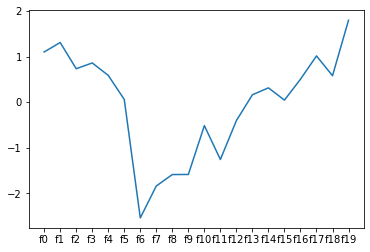

In [137]:
plt.plot(data.iloc[23,:p])
plt.show()

## Train - test - validation split

For reasons that will become clear later, we will split our data set in three parts. This is unlike the last time when it was just split in two parts. We will call the three parts training set, test set, and validation set.
We will use the training set to train our models (ma va?) and the test set to test the final model, as before. What is the purpose of the validation set then?

![Train test validation](ttv.png)

In [13]:
from sklearn.model_selection import train_test_split
X = data.iloc[:,:p]
y = data.iloc[:,p]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=888)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=37) # 0.8*0.25 = 0.2

## k-nearest neighbor classifier

Arguably the simples supevised classification method is the [k-nearest neighbor classifier](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html). It's also called [lazy learning](https://en.wikipedia.org/wiki/Lazy_learning).

It works as follows: given a new data point that we need to classify, consider the $k$ training data points that are nearest to it according to some distance on feature space. Predict the modal class of these. 

For example to classify an unseen image $x$ into cat or dog you find the $3$ images $x_1$, $x_2$, $x_3$ in your training set such that

\begin{equation}
    d(x, x_1) < d(x, x_2) < d(x, x_3) < d(x, y)
\end{equation}

for every other image $y$ in the dataset. Since these are training data you know the label of each, say for example that $x_1$ is a cat and $x_2$ and $x_3$ are dogs. Then you predict dog.

Even though it is in general rare, you could have some points that are exactly the same distance from $x$, so that strict inequalities do not hold above. Then you can break ties at random, for example. Another issue is when $k$ is even, so you can have an equal number of labels in each class within the $k$ neighbors. Scikit-learn solves it [like this](https://stats.stackexchange.com/questions/144718/how-does-scikit-learn-resolve-ties-in-the-knn-classification).

This can be generalized to weighed voting schemes, where for instance the nearest points among the $k$ neighbors count more. Instead of fixing the number of neigbors one can find neighbrs within a set radius, e.g. with [radius neighbor classifier](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.RadiusNeighborsClassifier.html#sklearn.neighbors.RadiusNeighborsClassifier) also in scikit-learn.

Another variant is to use only some representative points (obtained with some unsupervised method) rather than all the points in the data set, obtaining a [k-nearest prototype classifier](https://en.wikipedia.org/wiki/Nearest_centroid_classifier). Use your creativity to come up with new approaches if you like.

A general issue with these schemes, anyway, is that if you do not have enough data (an issue [especially in high dimensional spaces](https://en.wikipedia.org/wiki/Curse_of_dimensionality)) the neighbors are going to be quite far from the new point that needs to be classified.

In [20]:
from sklearn.neighbors import KNeighborsClassifier as knn

n1 = knn(n_neighbors=1)
n1.fit(X_train, y_train)
n1predictions = n1.predict(X_val)
print(n1predictions)

[0. 1. 0. 0. 1. 1. 0. 1. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 1. 0. 1. 1. 1. 1.
 0. 0. 1. 1. 1. 0. 1. 0. 1. 1. 0. 1. 0. 0. 0. 1.]


In [21]:
from sklearn.metrics import accuracy_score as accuracy

accuracy(y_val, n1predictions)

0.675

Ok...
Note that on the training data themselves the accuracy is going to be much higher, actually perfect for $k=1$

In [23]:
n1predictions_ontrain = n1.predict(X_train)
accuracy(y_train, n1predictions_ontrain)

1.0

This is a very very clear illustration of the need for an independent test set. Note also that in this case I used the validation set to test at this stage. This is not by mistake.

## Hyperparameter tuning

Let's see what happens when we change $k$. This is a tunable parameter of the method, also known as a hyperparameter.
We will train using different values of $k$ on the training set. Then we will pick the value that guarantees the best accuracy on the validation set. Finally, we will get an independent measurement of how accurate we are by testing on the test set.

In [25]:
def accuracy_given_k(k):
    nk = knn(n_neighbors=k)
    nk.fit(X_train, y_train)
    nkpredictions = nk.predict(X_val)
    return(accuracy(y_val , nkpredictions))

[accuracy_given_k(k) for k in 1+np.arange(8)]

[0.675, 0.625, 0.55, 0.575, 0.625, 0.625, 0.625, 0.625]

It seems reasonable that we would pick the $k$ that results in the best accuracy, so $k=1$.
Let's see how this works out on the test set then.

In [26]:
n1 = knn(n_neighbors=1)
n1.fit(X_train, y_train)
accuracy(y_test, n1.predict(X_test))

0.6

You see how the accuracy dropped on the test set. We can understand why by considering that we chose the best $k$ on the validation set. This way, even if all the choices of $k$ performed equally well we would still choose the one that appears better due to random fluctuations. But once we move to the test set this advantage is lost. If I choose the highest result when throwing two fair six-sided dice the expected value of the outcome is higher than 3.5. But if I throw that dice again it's 3.5 all over again.

## Cross validation
By the way, with this little data ($40$ data points in the validation set) how can I trust that $k=1$ did not perform better just by chance?

Obviously it would be great to have more data, but this is not always feasible (data points may be costly or unethical to acquire, or we may be dealing with a system that has intrisically few data points).

The question is then, are we making the best possible use of our data? Let's put the training and validation data back together. Instead of splitting them once we can do it many times and average the results. There is a standard way to do this and it's called [cross-validation](https://machinelearningmastery.com/k-fold-cross-validation), which is best explained with a picture.

![k-fold cross validation](kfold.png)

In [28]:
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.2, random_state=888)

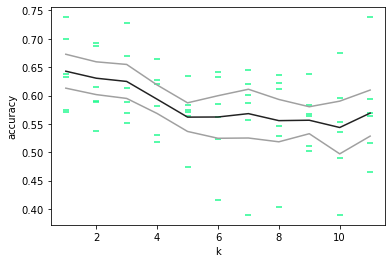

In [138]:
from sklearn.model_selection import cross_validate
folds = 6
kmax = 11
ks = []
results = []
for k in 1+np.arange(kmax):
    nk = knn(n_neighbors=k)
    cv_results = cross_validate(nk, X_trainval, y_trainval, cv=folds, scoring="accuracy")
    results = [*results, *cv_results['test_score']]
    ks = [*ks, *(k*np.ones(folds))]

ks = np.array(ks)
results = np.array(results)

jittering = 0.01*np.random.normal(size=len(results))    
plt.scatter(ks, results + jittering, s = 42, marker = "_", color = "#21FA90")
plt.xlabel("k")
plt.ylabel("accuracy")

cv_results = pd.DataFrame(data={"ks":ks, "results":results})
result_means = cv_results.groupby(["ks"]).mean()
result_std = np.sqrt(cv_results.groupby(["ks"]).var()/(folds-1))
plt.plot(result_means, color = "#222222")
plt.plot(result_means+result_std, color = "#A0A0A0")
plt.plot(result_means-result_std, color = "#A0A0A0")

plt.show()


It looks like we cannot really decide between $1$, $2$ or $3$. Using $1$ is faster so let's go with that.

In [142]:
n1 = knn(n_neighbors=3)
n1.fit(X_trainval, y_trainval)
accuracy(y_test, n1.predict(X_test))

0.55

By the way, the accuracy appears discrete (to the point I had to jitter it to see it better in the plot) because we have a small number of data points in the test set.

## Decision trees

[Decision trees](https://scikit-learn.org/stable/modules/tree.html) represent simple binary decision rules that are applied one after the other based on the result of the previous one. In such a tree each node represents a test, which is typically checking whether a given feature is above or below a threshold. Based on the result of the test we can move on to the next node, which can be either a further test or a terminal node (leaf). When we reach a leaf we make a decision to classify the instances corresponding to that leaf, i.e. those that pass each of the tests encountered along the way, as members of a given class.  

![Decision tree](treeDecision.png)



### Growing trees

How do we learn trees? As usual there are many ways. In scikit-learn they use [CART](https://en.wikipedia.org/wiki/Predictive_analytics#Classification_and_regression_trees_.28CART.29).
This boils down to a greedy splitting of feature space along one feature, with the feature and the level at which to split chosen to maximize a metric of how much purity is gained, such as the Gini index (see details [here](https://machinelearningmastery.com/classification-and-regression-trees-for-machine-learning)).


### Pruning trees
If we grow a tree all the way we end up having a classifier that may generalize poorly on new data. Moreover, the bigger a tree is the harder it is going to be to interpret. For these reasons we may want to reduce the size of the tree measured in terms of its leaves. This is called [pruning](https://scikit-learn.org/stable/modules/tree.html#minimal-cost-complexity-pruning).

By pruning we essentially merge back two or more gropus of data corresponding to leaves of the original tree. We are finding a subtree of the original tree. We want this subtree to minimize some loss, which will be a compromise between the number of leaves and a measure of classification accuracy or purity.

![Original tree](original.png)

![Pruned tree](pruned.png)


The loss used in scikit-learn's minimal cost-complexity pruning is
\begin{equation}
L_\alpha(T) = R(T) + \alpha |\tilde T|
\end{equation}

where $R(T)$ measures the impurity (or the misclassification rate) of the terminal nodes, so it is a measure of how good the predictions of the tree are on the training set, and $|\tilde T|$ is the number of leaves, which is a measure of the complexity of the tree. The parameter $\alpha$ decides how to weight the two terms in the overall loss, with $\alpha=0$ (the default) meaning no pruning occurs.

In [128]:
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier(random_state=888)
tree.fit(X_train, y_train)
tree_predictions = tree.predict(X_val)
accuracy(y_val, tree_predictions)

0.575

Note that for this unpruned tree (not pruning is the default in scikit-learn) we have perfect accuracy on the training set. But that is not of much use when generalizing to the unseen validation set.

In [101]:
tree_predictions_train = tree.predict(X_train)
accuracy(y_train, tree_predictions_train)

1.0

In [135]:
tree_pruned = DecisionTreeClassifier(random_state=888, ccp_alpha=0.045)
tree_pruned.fit(X_train, y_train)
tree_pruned_predictions = tree_pruned.predict(X_val)
accuracy(y_val, tree_pruned_predictions)

0.6

So pruning improves generalization (I cheated). Again, how much to prune (the value of $\alpha$ above) can be decided by cross-validation.

Let's compare the pruned and unpruned trees:

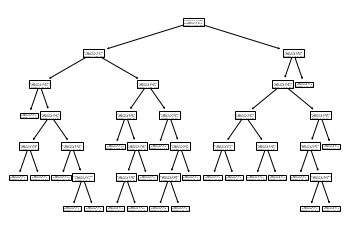

In [115]:
from sklearn.tree import plot_tree
plot_tree(tree)
plt.show()

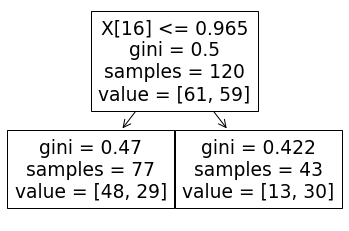

In [136]:
plot_tree(tree_pruned)
plt.show()